In [1]:
using Plots
using Base: Slice, OneTo
using Random
using StatsBase

# Dataset for tests

In [2]:
function malanchev_dataset(; inliers=2^10, outliers=2^5)
    s = Float32(0.1)
    return hcat(
        rand(Float32, 2, inliers) ./ 2,
        randn(Float32, 2, outliers) .* s .+ [1; 1],
        randn(Float32, 2, outliers) .* s .+ [0; 1],
        randn(Float32, 2, outliers) .* s .+ [1; 0])
end

malanchev_dataset (generic function with 1 method)

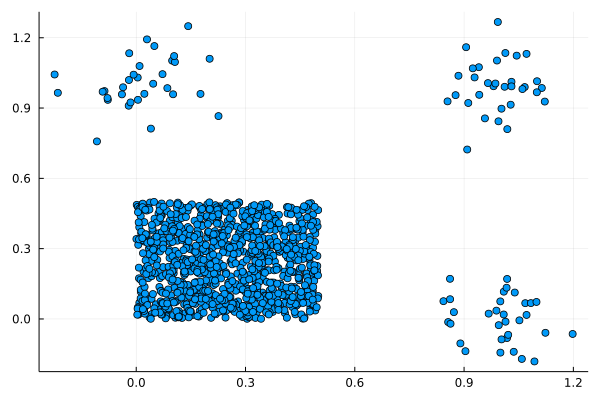

In [3]:
scatter(eachrow(malanchev_dataset())...; legend=nothing)

# Isolation forest structures

In [4]:
"Tree node. It selects the `feature` and using the `threshold` decided
which subtree to go into: left one or right one.

The case feature = left = right = 0 is special for tip node.
In that case threshold means `total path length from the root`."
mutable struct Node{T}
    feature::Int32
    left::Int32
    right::Int32
    threshold::T
end


"Tree is an array of nodes"
const Tree{T} = Vector{Node{T}}


"Forest is an array. We hold a few helpful parameters here."
struct Forest{T}
    trees::Vector{Tree{T}}
    subsamples::Int
    maxdepth::Int
end


"Auxiliary view type for the internal use in subtree constructions."
const SubData{T} = SubArray{T, 2, Matrix{T}, Tuple{Slice{OneTo{Int64}}, UnitRange{Int}}, true}

SubData

# Average path length in tree

In [5]:
"Average path length in tree with n tip nodes."
@inline function average_path_length(::Type{T}, n::Int32)::T where T <: Real
    γ = T(MathConstants.γ)
    return n == 1 ? 0 : 2 * (log(n) + γ + 1 / 2 / n - (1 / n)^2 / 12 - 1)
    # Thank you Matwey.
end

average_path_length

# Construction of trees and forest growing

In [6]:
"Isolation forest construction. For each tree we subsample n_samples out of
the initial data. Maximum depth of the constructed trees is maxdepth,
number of trees in forest is n_trees."
function build_forest(
        data::Matrix{T};
        rng::R=Random.GLOBAL_RNG,
        n_samples::Int,
        n_trees::Int,
        maxdepth::Int32)::Forest{T} where {T <: Real, R <: AbstractRNG}
    
    trees = Vector{Tree{T}}(undef, n_trees)
    
    for i in 1:n_trees
        subsamples = sample(axes(data, 2), n_samples; replace=false)
        subdata = data[:, subsamples]
        
        trees[i] = build_tree!(subdata; rng, maxdepth)
    end

    return Forest{T}(trees, n_samples, maxdepth)
end


"Tree construction. The data is gonna be modified (permuted) to resemble
the division in subtrees."
function build_tree!(
        data::Matrix{T};
        rng::R,
        maxdepth::Int32)::Tree{T} where {T <: Real, R <: AbstractRNG}

    tree = Tree{T}(undef, 0)
    view_data = @view data[:, begin:end]
    build_subtree!(view_data, tree, Int32(0), rng; maxdepth)
    return tree
end


"The main function in tree construction is a construction of subtree.
Growing the whole tree is just a special case of this one."
function build_subtree!(
        subdata::SubData{T},
        tree::Tree,
        depth::Int32,
        rng::R;
        maxdepth::Int32)::Tuple{Int,Int} where {T <: Real, R <: AbstractRNG}
    
    first, last = extrema(axes(subdata, 2))
    n = Int32(last - first + 1)
    if (n < 2) || (depth == maxdepth)
        z = Int32(0)
        push!(tree, Node(z, z, z, depth + average_path_length(T, n)))
        _, root = extrema(axes(tree, 1))
        return (root, root)
    end
    
    feature = Int32(rand(rng, axes(subdata, 1)))
    min, max = extrema(subdata[feature, :])
    threshold = min + rand(rng, T) * (max - min)
    
    z = Int32(0)
    push!(tree, Node(feature, z, z, threshold))
    _, root = extrema(axes(tree, 1))
    
    nextdepth = depth + Int32(1)
    left, right = split_subarray!(subdata, feature, threshold)
    root_left, _ = build_subtree!(left, tree, nextdepth, rng; maxdepth)
    root_right, tip_right = build_subtree!(right, tree, nextdepth, rng; maxdepth)
    
    tree[root].left = root_left
    tree[root].right = root_right

    return (root, tip_right)
end


"Splitting (permuting) the data in two halves with pivot as a threshold. The data is modified.
The algorithm is the same as in quicksort."
function split_subarray!(data::SubData{T}, feature::Int32, pivot::T)::Tuple{SubData{T}, SubData{T}} where T <: Real
    left, right = extrema(axes(data, 2))
    while true
        while data[feature, left] < pivot
            left += 1
        end

        while data[feature, right] >= pivot
            right -= 1
        end

        (left < right) || break

        (data[:, left], data[:, right]) = (data[:, right], data[:, left])
    end

    # At the point index `right` is bigger than index `left`
    vleft = @view data[:, begin:right]
    vright = @view data[:, left:end]
    return (vleft, vright)
end

split_subarray!

# Calculation of scores

In [7]:
"Evaluation of tree path length on the given data point."
function pathlength(tree::Tree, sample::Vector{T})::T where T <: Real
    index = 1
    feature = tree[index].feature

    while feature != 0
        if sample[feature] < tree[index].threshold
            index = tree[index].left
        else
            index = tree[index].right
        end
        
        feature = tree[index].feature
    end

    return tree[index].threshold
end


"Estimation of the mean score of the given samples with the given forest."
function score(forest::Forest, samples::Matrix{T})::Vector{T} where T <: Real
    n_trees = length(forest.trees)

    scores = similar(Vector{T}, (axes(samples, 2),))
    scores[:] .= 0

    for i in eachindex(scores)
        for tree in forest.trees
            scores[i] += pathlength(tree, samples[:, i])
        end

        scores[i] /= n_trees
    end
    
    return -2 .^ (-scores ./ average_path_length(T, Int32(forest.subsamples)))
end

score

# Example

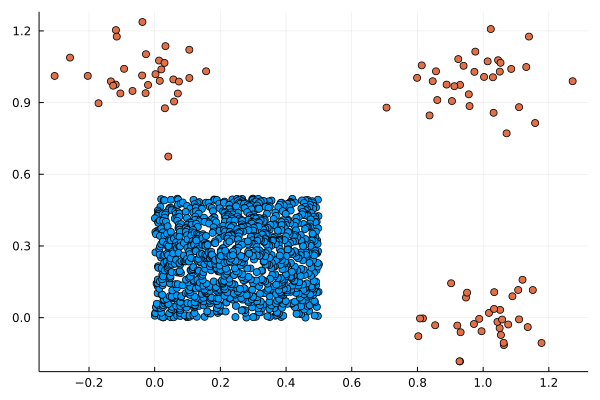

In [8]:
data = malanchev_dataset()
forest = build_forest(data; n_samples=16, n_trees=1000, maxdepth=Int32(4))
scores = score(forest, data)
sorting = sortperm(scores)

scatter(eachrow(data[:, sorting[begin:96]])...; legend=nothing, c=2)
scatter!(eachrow(data[:, sorting[97:end]])...; legend=nothing, c=1)

# Tests

In [9]:
data = malanchev_dataset(inliers=2^13);

In [10]:
@time isoforest = build_forest(data, n_trees=200, n_samples=1024, maxdepth=Int32(10));

  0.095799 seconds (701.21 k allocations: 84.072 MiB, 10.63% gc time, 14.58% compilation time)


# Concerns

## Harmonic number approx

In [11]:
harmonic(n::Int)::Float32 = sum(1/i for i in n:-1:1)
zero_approx(n::Int)::Float32 = log(n) + MathConstants.γ
first_approx(n::Int)::Float32 = log(n) + MathConstants.γ + 1 / (2 * n)
second_approx(n::Int)::Float32 = log(n) + MathConstants.γ + 1 / (2 * n) - 1 / (12 * n^2)

second_approx (generic function with 1 method)

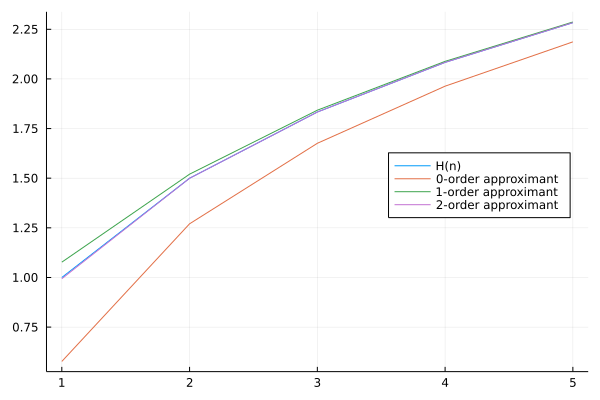

In [12]:
ns = 1:5
plot(ns, harmonic.(ns); label="H(n)", legend=:right)
plot!(ns, zero_approx.(ns); label="0-order approximant")
plot!(ns, first_approx.(ns); label="1-order approximant")
plot!(ns, second_approx.(ns); label="2-order approximant")